In [ ]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from tqdm import tqdm
from datetime import datetime


import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [55]:
print("CUDA available:", torch.cuda.is_available())  
print("CUDA version:", torch.version.cuda)          
print("Device:", torch.device("cuda"))             
print("GPU name:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA available: True
CUDA version: 13.0
Device: cuda
GPU name: NVIDIA GeForce RTX 3060


In [56]:
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])
dataset = datasets.ImageFolder(root='Faulty_solar_panel', transform=transform)
print("Dataset size:", len(dataset))
print("Classes:", dataset.classes)
num_classes = len(dataset.classes)


Dataset size: 1207
Classes: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


In [57]:
orig_indices = []
aug_indices = []

for idx, (path, _) in enumerate(dataset.samples):
    filename = os.path.basename(path)
    if filename.startswith("aug_"):
        aug_indices.append(idx)
    else:
        orig_indices.append(idx)

print("Original Count:", len(orig_indices))
print("Augmented Count:", len(aug_indices))

Original Count: 885
Augmented Count: 322


In [58]:
total_orig = len(orig_indices)
val_size = int(total_orig * 0.15)
test_size = int(total_orig * 0.15)
train_orig_size = total_orig - val_size - test_size

train_orig, val_orig, test_orig = random_split(
    orig_indices, [train_orig_size, val_size, test_size]
)

train_indices = list(train_orig) + aug_indices
val_indices = list(val_orig)
test_indices = list(test_orig)

train_ds = Subset(dataset, train_indices)
val_ds   = Subset(dataset, val_indices)
test_ds  = Subset(dataset, test_indices)

print("Train size:", len(train_ds))
print("Validation size:", len(val_ds))
print("Test size:", len(test_ds))

Train size: 943
Validation size: 132
Test size: 132


In [103]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True, num_workers=4,drop_last=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, pin_memory=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, pin_memory=True, num_workers=4, drop_last=True)

print("Train size:", len(train_loader.dataset))
print("Validation size:", len(val_loader.dataset))
print("Test size:", len(test_loader.dataset))

Train size: 943
Validation size: 132
Test size: 132


In [60]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # [3,256,256] -> [16,128,128]
            nn.ReLU(),
            nn.Conv2d(16,32,3,stride=2,padding=1),    # [16,128,128] -> [32,64,64]
            nn.ReLU(),
            nn.Conv2d(32,64,3,stride=2,padding=1),    # [32,64,64] -> [64,32,32]
            nn.ReLU(),
            nn.Conv2d(64,128,3,stride=2,padding=1),   # [64,32,32] -> [128,16,16]
            nn.ReLU(),
            nn.Conv2d(128,256,3,stride=2,padding=1),   # [64,32,32] -> [128,16,16]
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256,128,3,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128,64,3,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64,32,3,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,3,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16,3,3,stride=2,padding=1,output_padding=1),
            nn.Sigmoid()
        )

    def forward(self,x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon

autoencoder = Autoencoder().to(device)


In [102]:
ae_criterion = nn.MSELoss()
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
num_ae_epochs = 20
ae_losses = torch.zeros(num_ae_epochs)

for epoch in range(num_ae_epochs):
    batchLoss = []
    for images, _ in tqdm(train_loader):
        images = images.to(device)
        outputs = autoencoder(images)
        loss = ae_criterion(outputs, images)

        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()

        batchLoss.append(loss.item())

    epoch_loss = sum(batchLoss) / len(batchLoss)
    ae_losses[epoch] = epoch_loss
    print(f"AE Epoch [{epoch+1}/{num_ae_epochs}], Loss: {epoch_loss:.6f}")



100%|██████████| 30/30 [00:24<00:00,  1.24it/s]


AE Epoch [1/20], Loss: 0.430736


100%|██████████| 30/30 [00:24<00:00,  1.24it/s]


AE Epoch [2/20], Loss: 0.254295


100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


AE Epoch [3/20], Loss: 0.213490


100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


AE Epoch [4/20], Loss: 0.207588


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


AE Epoch [5/20], Loss: 0.202376


100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


AE Epoch [6/20], Loss: 0.196871


100%|██████████| 30/30 [00:23<00:00,  1.28it/s]


AE Epoch [7/20], Loss: 0.194642


100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


AE Epoch [8/20], Loss: 0.194510


100%|██████████| 30/30 [00:23<00:00,  1.25it/s]


AE Epoch [9/20], Loss: 0.193956


 40%|████      | 12/30 [00:16<00:24,  1.37s/it]


KeyboardInterrupt: 

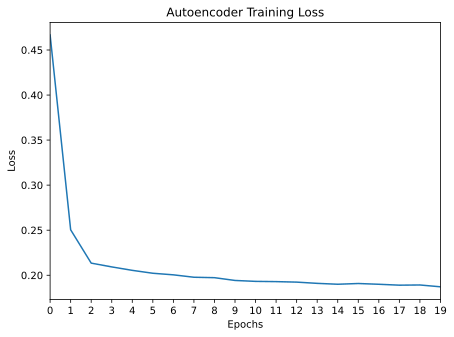

In [62]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(ae_losses.cpu().numpy())
ax.set_xticks(np.arange(0, num_ae_epochs, 1))
ax.set_xlabel('Epochs')
ax.set_title('Autoencoder Training Loss')
ax.set_ylabel('Loss')
ax.set_xlim([0,19])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7647059..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


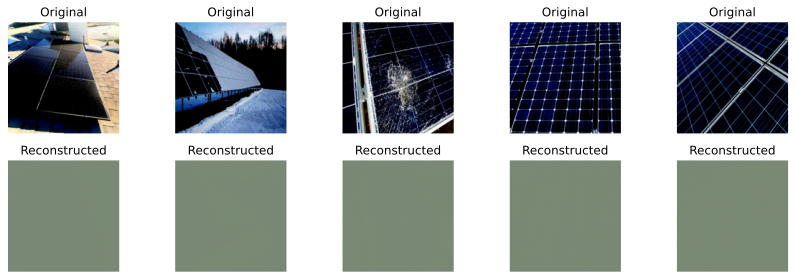

In [ ]:
with torch.no_grad():
    images, _ = random.choice(list(test_loader))
    images = images.to(device)
    outputs = autoencoder(images)
    
    images = images.cpu()
    outputs = outputs.cpu()

num_images = 5
plt.figure(figsize=(12, 4))
for i in range(num_images):

    plt.subplot(2, num_images, i+1)
    plt.imshow(images[i].permute(1,2,0).numpy())
    plt.title("Original")
    plt.axis("off")


    plt.subplot(2, num_images, i+1+num_images)
    plt.imshow(outputs[i].permute(1,2,0).numpy())
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [64]:
class Classifier(nn.Module):
    def __init__(self, latent_channels=256, num_classes=6):
        super(Classifier, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(latent_channels,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )
    def forward(self,x):
        x = self.pool(x)
        x = self.fc(x)
        return x

classifier = Classifier(latent_channels=256, num_classes=num_classes).to(device)

In [65]:
for param in autoencoder.encoder.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(autoencoder.encoder.parameters()) + list(classifier.parameters()), lr=1e-4)

In [66]:
print("Training classifier with encoder fine-tuning...")
num_epochs = 300
losses = torch.zeros(num_epochs)
train_acc  = []
val_acc = []
for epoch in range(num_epochs):
    batch_acc  = []
    batch_loss = []
    
    autoencoder.encoder.train()
    classifier.train()
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        latent = autoencoder.encoder(images)
        outputs = classifier(latent)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())
        batch_acc.append(100*torch.mean((torch.argmax(outputs,axis=1) == labels).float()).item())

    train_acc.append(np.mean(batch_acc))
    losses[epoch] = np.mean(batch_loss)
    

    
    autoencoder.encoder.eval()
    classifier.eval()
    val_batch_acc = []
    for images_val, labels_val in val_loader:
         
        with torch.no_grad():
            images_val, labels_val = images_val.to(device), labels_val.to(device)
            latent_val = autoencoder.encoder(images_val)
            outputs_val = classifier(latent_val)
            val_batch_acc.append(100*torch.mean((torch.argmax(outputs_val,axis=1)==labels_val).float()).item())
    
    val_acc.append(np.mean(val_batch_acc))
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Loss: {losses[epoch]:.4f}, Train Accuracy: {train_acc[epoch]:.2f}%, Validation Accuracy: {val_acc[epoch]:.2f}%")

Training classifier with encoder fine-tuning...


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [1/300]
Loss: 1.7857, Train Accuracy: 18.57%, Validation Accuracy: 14.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [2/300]
Loss: 1.7545, Train Accuracy: 22.03%, Validation Accuracy: 16.88%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [3/300]
Loss: 1.7056, Train Accuracy: 25.68%, Validation Accuracy: 14.38%


100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


Epoch [4/300]
Loss: 1.7036, Train Accuracy: 27.03%, Validation Accuracy: 22.50%


100%|██████████| 30/30 [00:25<00:00,  1.20it/s]


Epoch [5/300]
Loss: 1.6900, Train Accuracy: 27.45%, Validation Accuracy: 22.50%


100%|██████████| 30/30 [00:23<00:00,  1.26it/s]


Epoch [6/300]
Loss: 1.6841, Train Accuracy: 26.13%, Validation Accuracy: 23.75%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [7/300]
Loss: 1.6902, Train Accuracy: 29.12%, Validation Accuracy: 28.12%


100%|██████████| 30/30 [00:22<00:00,  1.30it/s]


Epoch [8/300]
Loss: 1.6762, Train Accuracy: 28.52%, Validation Accuracy: 25.00%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [9/300]
Loss: 1.6705, Train Accuracy: 29.43%, Validation Accuracy: 28.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [10/300]
Loss: 1.6624, Train Accuracy: 30.40%, Validation Accuracy: 27.50%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [11/300]
Loss: 1.6622, Train Accuracy: 30.71%, Validation Accuracy: 23.12%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [12/300]
Loss: 1.6609, Train Accuracy: 30.77%, Validation Accuracy: 31.25%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [13/300]
Loss: 1.6634, Train Accuracy: 29.12%, Validation Accuracy: 30.00%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [14/300]
Loss: 1.6476, Train Accuracy: 31.36%, Validation Accuracy: 30.62%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [15/300]
Loss: 1.6564, Train Accuracy: 31.35%, Validation Accuracy: 36.88%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [16/300]
Loss: 1.6411, Train Accuracy: 32.30%, Validation Accuracy: 34.38%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [17/300]
Loss: 1.6040, Train Accuracy: 34.81%, Validation Accuracy: 33.75%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [18/300]
Loss: 1.5960, Train Accuracy: 32.48%, Validation Accuracy: 33.75%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [19/300]
Loss: 1.5999, Train Accuracy: 33.15%, Validation Accuracy: 39.38%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [20/300]
Loss: 1.5656, Train Accuracy: 36.45%, Validation Accuracy: 46.88%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [21/300]
Loss: 1.5585, Train Accuracy: 36.69%, Validation Accuracy: 28.75%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [22/300]
Loss: 1.5445, Train Accuracy: 37.15%, Validation Accuracy: 45.00%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [23/300]
Loss: 1.5528, Train Accuracy: 37.73%, Validation Accuracy: 42.50%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [24/300]
Loss: 1.5256, Train Accuracy: 40.23%, Validation Accuracy: 38.12%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [25/300]
Loss: 1.5171, Train Accuracy: 39.01%, Validation Accuracy: 47.50%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [26/300]
Loss: 1.5178, Train Accuracy: 39.26%, Validation Accuracy: 46.88%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [27/300]
Loss: 1.5149, Train Accuracy: 39.76%, Validation Accuracy: 47.50%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [28/300]
Loss: 1.5178, Train Accuracy: 38.26%, Validation Accuracy: 45.00%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [29/300]
Loss: 1.4837, Train Accuracy: 40.72%, Validation Accuracy: 50.00%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [30/300]
Loss: 1.4843, Train Accuracy: 43.42%, Validation Accuracy: 43.75%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [31/300]
Loss: 1.4762, Train Accuracy: 42.57%, Validation Accuracy: 50.00%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [32/300]
Loss: 1.4587, Train Accuracy: 42.76%, Validation Accuracy: 43.12%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [33/300]
Loss: 1.4889, Train Accuracy: 41.67%, Validation Accuracy: 48.12%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [34/300]
Loss: 1.4444, Train Accuracy: 41.88%, Validation Accuracy: 45.62%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [35/300]
Loss: 1.4447, Train Accuracy: 43.74%, Validation Accuracy: 45.62%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [36/300]
Loss: 1.4625, Train Accuracy: 43.74%, Validation Accuracy: 43.75%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [37/300]
Loss: 1.4368, Train Accuracy: 42.76%, Validation Accuracy: 50.62%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [38/300]
Loss: 1.3988, Train Accuracy: 45.84%, Validation Accuracy: 51.25%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [39/300]
Loss: 1.4116, Train Accuracy: 45.58%, Validation Accuracy: 48.75%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [40/300]
Loss: 1.4158, Train Accuracy: 45.02%, Validation Accuracy: 45.62%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [41/300]
Loss: 1.4292, Train Accuracy: 43.52%, Validation Accuracy: 43.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [42/300]
Loss: 1.4028, Train Accuracy: 44.04%, Validation Accuracy: 48.75%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [43/300]
Loss: 1.3862, Train Accuracy: 45.68%, Validation Accuracy: 45.62%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [44/300]
Loss: 1.3818, Train Accuracy: 47.30%, Validation Accuracy: 48.75%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [45/300]
Loss: 1.3707, Train Accuracy: 47.27%, Validation Accuracy: 46.88%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [46/300]
Loss: 1.3683, Train Accuracy: 44.20%, Validation Accuracy: 48.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [47/300]
Loss: 1.3685, Train Accuracy: 45.10%, Validation Accuracy: 45.62%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [48/300]
Loss: 1.3603, Train Accuracy: 46.03%, Validation Accuracy: 50.00%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [49/300]
Loss: 1.3378, Train Accuracy: 47.43%, Validation Accuracy: 47.50%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [50/300]
Loss: 1.3612, Train Accuracy: 46.44%, Validation Accuracy: 46.88%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [51/300]
Loss: 1.3503, Train Accuracy: 47.48%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [52/300]
Loss: 1.3470, Train Accuracy: 45.83%, Validation Accuracy: 51.25%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [53/300]
Loss: 1.3354, Train Accuracy: 45.90%, Validation Accuracy: 48.75%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [54/300]
Loss: 1.3243, Train Accuracy: 46.83%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [55/300]
Loss: 1.3061, Train Accuracy: 49.59%, Validation Accuracy: 47.50%


100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


Epoch [56/300]
Loss: 1.3538, Train Accuracy: 46.44%, Validation Accuracy: 48.75%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [57/300]
Loss: 1.3149, Train Accuracy: 46.56%, Validation Accuracy: 51.88%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [58/300]
Loss: 1.3205, Train Accuracy: 47.51%, Validation Accuracy: 53.75%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [59/300]
Loss: 1.3216, Train Accuracy: 47.42%, Validation Accuracy: 53.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [60/300]
Loss: 1.2913, Train Accuracy: 48.12%, Validation Accuracy: 45.62%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [61/300]
Loss: 1.2759, Train Accuracy: 49.93%, Validation Accuracy: 48.75%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [62/300]
Loss: 1.2804, Train Accuracy: 49.71%, Validation Accuracy: 45.00%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [63/300]
Loss: 1.3259, Train Accuracy: 47.57%, Validation Accuracy: 48.75%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [64/300]
Loss: 1.2755, Train Accuracy: 49.78%, Validation Accuracy: 50.62%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [65/300]
Loss: 1.2713, Train Accuracy: 49.68%, Validation Accuracy: 46.88%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [66/300]
Loss: 1.2854, Train Accuracy: 48.43%, Validation Accuracy: 51.25%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [67/300]
Loss: 1.2421, Train Accuracy: 49.80%, Validation Accuracy: 48.75%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [68/300]
Loss: 1.2538, Train Accuracy: 50.22%, Validation Accuracy: 46.88%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [69/300]
Loss: 1.2737, Train Accuracy: 49.68%, Validation Accuracy: 55.00%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [70/300]
Loss: 1.2589, Train Accuracy: 51.06%, Validation Accuracy: 47.50%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [71/300]
Loss: 1.2651, Train Accuracy: 50.02%, Validation Accuracy: 54.38%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [72/300]
Loss: 1.2341, Train Accuracy: 52.13%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [73/300]
Loss: 1.2672, Train Accuracy: 50.53%, Validation Accuracy: 50.62%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [74/300]
Loss: 1.2318, Train Accuracy: 50.69%, Validation Accuracy: 48.12%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [75/300]
Loss: 1.2014, Train Accuracy: 51.26%, Validation Accuracy: 50.00%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [76/300]
Loss: 1.2491, Train Accuracy: 49.69%, Validation Accuracy: 51.25%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [77/300]
Loss: 1.2179, Train Accuracy: 52.82%, Validation Accuracy: 55.00%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [78/300]
Loss: 1.2470, Train Accuracy: 52.05%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [79/300]
Loss: 1.2132, Train Accuracy: 52.31%, Validation Accuracy: 55.00%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [80/300]
Loss: 1.2337, Train Accuracy: 50.57%, Validation Accuracy: 48.12%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [81/300]
Loss: 1.2026, Train Accuracy: 52.27%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [82/300]
Loss: 1.2221, Train Accuracy: 51.53%, Validation Accuracy: 50.62%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [83/300]
Loss: 1.1929, Train Accuracy: 54.40%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [84/300]
Loss: 1.2132, Train Accuracy: 52.43%, Validation Accuracy: 54.38%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [85/300]
Loss: 1.1872, Train Accuracy: 52.49%, Validation Accuracy: 48.75%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [86/300]
Loss: 1.2095, Train Accuracy: 50.32%, Validation Accuracy: 51.88%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [87/300]
Loss: 1.1650, Train Accuracy: 54.50%, Validation Accuracy: 48.75%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [88/300]
Loss: 1.1870, Train Accuracy: 51.78%, Validation Accuracy: 47.50%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [89/300]
Loss: 1.1862, Train Accuracy: 54.93%, Validation Accuracy: 48.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [90/300]
Loss: 1.2022, Train Accuracy: 53.07%, Validation Accuracy: 52.50%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [91/300]
Loss: 1.1505, Train Accuracy: 53.47%, Validation Accuracy: 56.25%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [92/300]
Loss: 1.1805, Train Accuracy: 52.92%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [93/300]
Loss: 1.1914, Train Accuracy: 51.24%, Validation Accuracy: 50.62%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [94/300]
Loss: 1.1670, Train Accuracy: 54.72%, Validation Accuracy: 50.62%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [95/300]
Loss: 1.1603, Train Accuracy: 54.62%, Validation Accuracy: 48.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [96/300]
Loss: 1.1787, Train Accuracy: 54.81%, Validation Accuracy: 48.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [97/300]
Loss: 1.1493, Train Accuracy: 54.37%, Validation Accuracy: 53.12%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [98/300]
Loss: 1.1634, Train Accuracy: 52.49%, Validation Accuracy: 44.38%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [99/300]
Loss: 1.1581, Train Accuracy: 53.69%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [100/300]
Loss: 1.1583, Train Accuracy: 54.16%, Validation Accuracy: 50.62%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [101/300]
Loss: 1.1423, Train Accuracy: 54.23%, Validation Accuracy: 48.12%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [102/300]
Loss: 1.1048, Train Accuracy: 54.62%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [103/300]
Loss: 1.1406, Train Accuracy: 53.65%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [104/300]
Loss: 1.1351, Train Accuracy: 53.52%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [105/300]
Loss: 1.1258, Train Accuracy: 56.08%, Validation Accuracy: 48.75%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [106/300]
Loss: 1.1673, Train Accuracy: 53.67%, Validation Accuracy: 50.00%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [107/300]
Loss: 1.1096, Train Accuracy: 57.00%, Validation Accuracy: 54.38%


100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


Epoch [108/300]
Loss: 1.1320, Train Accuracy: 54.90%, Validation Accuracy: 58.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [109/300]
Loss: 1.1394, Train Accuracy: 53.79%, Validation Accuracy: 51.25%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [110/300]
Loss: 1.1086, Train Accuracy: 57.83%, Validation Accuracy: 46.88%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [111/300]
Loss: 1.1293, Train Accuracy: 54.99%, Validation Accuracy: 52.50%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [112/300]
Loss: 1.1069, Train Accuracy: 57.21%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [113/300]
Loss: 1.1024, Train Accuracy: 56.02%, Validation Accuracy: 50.00%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [114/300]
Loss: 1.0983, Train Accuracy: 57.94%, Validation Accuracy: 54.38%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [115/300]
Loss: 1.0544, Train Accuracy: 58.13%, Validation Accuracy: 48.75%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [116/300]
Loss: 1.0747, Train Accuracy: 57.61%, Validation Accuracy: 52.50%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [117/300]
Loss: 1.1204, Train Accuracy: 54.78%, Validation Accuracy: 45.00%


100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


Epoch [118/300]
Loss: 1.0989, Train Accuracy: 55.85%, Validation Accuracy: 52.50%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [119/300]
Loss: 1.0840, Train Accuracy: 56.17%, Validation Accuracy: 51.88%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [120/300]
Loss: 1.0644, Train Accuracy: 57.19%, Validation Accuracy: 52.50%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [121/300]
Loss: 1.0654, Train Accuracy: 57.91%, Validation Accuracy: 53.75%


100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


Epoch [122/300]
Loss: 1.0448, Train Accuracy: 59.01%, Validation Accuracy: 48.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [123/300]
Loss: 1.0556, Train Accuracy: 57.81%, Validation Accuracy: 53.75%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [124/300]
Loss: 1.0444, Train Accuracy: 56.92%, Validation Accuracy: 50.00%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [125/300]
Loss: 1.0463, Train Accuracy: 59.63%, Validation Accuracy: 51.25%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [126/300]
Loss: 1.0481, Train Accuracy: 60.02%, Validation Accuracy: 53.75%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [127/300]
Loss: 1.0907, Train Accuracy: 57.42%, Validation Accuracy: 52.50%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [128/300]
Loss: 1.0296, Train Accuracy: 60.05%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [129/300]
Loss: 1.0257, Train Accuracy: 58.56%, Validation Accuracy: 48.12%


100%|██████████| 30/30 [00:23<00:00,  1.28it/s]


Epoch [130/300]
Loss: 1.0509, Train Accuracy: 60.29%, Validation Accuracy: 61.88%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [131/300]
Loss: 1.0131, Train Accuracy: 58.24%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [132/300]
Loss: 1.0449, Train Accuracy: 58.33%, Validation Accuracy: 43.12%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [133/300]
Loss: 1.0320, Train Accuracy: 60.03%, Validation Accuracy: 53.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [134/300]
Loss: 1.0062, Train Accuracy: 58.65%, Validation Accuracy: 53.75%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [135/300]
Loss: 0.9895, Train Accuracy: 60.23%, Validation Accuracy: 53.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [136/300]
Loss: 1.0116, Train Accuracy: 58.76%, Validation Accuracy: 48.75%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [137/300]
Loss: 1.0088, Train Accuracy: 59.72%, Validation Accuracy: 54.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [138/300]
Loss: 0.9935, Train Accuracy: 60.40%, Validation Accuracy: 53.75%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [139/300]
Loss: 0.9698, Train Accuracy: 60.81%, Validation Accuracy: 50.00%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [140/300]
Loss: 0.9925, Train Accuracy: 59.51%, Validation Accuracy: 54.38%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [141/300]
Loss: 1.0072, Train Accuracy: 59.49%, Validation Accuracy: 53.75%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [142/300]
Loss: 0.9384, Train Accuracy: 62.95%, Validation Accuracy: 56.25%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [143/300]
Loss: 1.0222, Train Accuracy: 58.99%, Validation Accuracy: 60.62%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [144/300]
Loss: 0.9251, Train Accuracy: 64.53%, Validation Accuracy: 53.12%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [145/300]
Loss: 0.9485, Train Accuracy: 60.96%, Validation Accuracy: 56.25%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [146/300]
Loss: 0.9866, Train Accuracy: 61.70%, Validation Accuracy: 50.00%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [147/300]
Loss: 0.9467, Train Accuracy: 63.47%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [148/300]
Loss: 0.9312, Train Accuracy: 64.29%, Validation Accuracy: 55.62%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [149/300]
Loss: 0.9864, Train Accuracy: 61.27%, Validation Accuracy: 53.12%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [150/300]
Loss: 0.9437, Train Accuracy: 62.40%, Validation Accuracy: 54.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [151/300]
Loss: 0.9001, Train Accuracy: 63.50%, Validation Accuracy: 48.75%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [152/300]
Loss: 0.9252, Train Accuracy: 63.19%, Validation Accuracy: 53.75%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [153/300]
Loss: 0.9188, Train Accuracy: 63.58%, Validation Accuracy: 48.75%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [154/300]
Loss: 0.8690, Train Accuracy: 65.76%, Validation Accuracy: 55.00%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [155/300]
Loss: 0.9299, Train Accuracy: 64.29%, Validation Accuracy: 56.88%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [156/300]
Loss: 0.9212, Train Accuracy: 62.63%, Validation Accuracy: 54.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [157/300]
Loss: 0.8975, Train Accuracy: 64.29%, Validation Accuracy: 55.62%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [158/300]
Loss: 0.9333, Train Accuracy: 62.70%, Validation Accuracy: 61.25%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [159/300]
Loss: 0.8831, Train Accuracy: 64.77%, Validation Accuracy: 61.25%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [160/300]
Loss: 0.9118, Train Accuracy: 64.38%, Validation Accuracy: 55.62%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [161/300]
Loss: 0.9071, Train Accuracy: 63.86%, Validation Accuracy: 54.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [162/300]
Loss: 0.9150, Train Accuracy: 64.74%, Validation Accuracy: 57.50%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [163/300]
Loss: 0.9228, Train Accuracy: 64.08%, Validation Accuracy: 55.00%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [164/300]
Loss: 0.8789, Train Accuracy: 65.81%, Validation Accuracy: 61.88%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [165/300]
Loss: 0.8259, Train Accuracy: 67.33%, Validation Accuracy: 51.25%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [166/300]
Loss: 0.8565, Train Accuracy: 66.51%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [167/300]
Loss: 0.8723, Train Accuracy: 64.84%, Validation Accuracy: 54.38%


100%|██████████| 30/30 [00:23<00:00,  1.28it/s]


Epoch [168/300]
Loss: 0.8626, Train Accuracy: 64.22%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [169/300]
Loss: 0.8484, Train Accuracy: 65.62%, Validation Accuracy: 52.50%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [170/300]
Loss: 0.8558, Train Accuracy: 66.47%, Validation Accuracy: 56.25%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [171/300]
Loss: 0.8402, Train Accuracy: 66.85%, Validation Accuracy: 55.62%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [172/300]
Loss: 0.8768, Train Accuracy: 64.47%, Validation Accuracy: 51.25%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [173/300]
Loss: 0.8262, Train Accuracy: 67.63%, Validation Accuracy: 53.75%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [174/300]
Loss: 0.8289, Train Accuracy: 66.69%, Validation Accuracy: 48.12%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [175/300]
Loss: 0.8328, Train Accuracy: 64.46%, Validation Accuracy: 60.00%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [176/300]
Loss: 0.8072, Train Accuracy: 67.90%, Validation Accuracy: 62.50%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [177/300]
Loss: 0.7886, Train Accuracy: 67.92%, Validation Accuracy: 63.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [178/300]
Loss: 0.8273, Train Accuracy: 67.39%, Validation Accuracy: 56.88%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [179/300]
Loss: 0.7990, Train Accuracy: 68.89%, Validation Accuracy: 61.25%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [180/300]
Loss: 0.8906, Train Accuracy: 64.40%, Validation Accuracy: 60.00%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [181/300]
Loss: 0.7624, Train Accuracy: 69.24%, Validation Accuracy: 56.25%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [182/300]
Loss: 0.7916, Train Accuracy: 68.68%, Validation Accuracy: 57.50%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [183/300]
Loss: 0.7502, Train Accuracy: 70.48%, Validation Accuracy: 56.88%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [184/300]
Loss: 0.8299, Train Accuracy: 67.77%, Validation Accuracy: 50.00%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [185/300]
Loss: 0.7849, Train Accuracy: 69.38%, Validation Accuracy: 51.88%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [186/300]
Loss: 0.9826, Train Accuracy: 63.95%, Validation Accuracy: 51.25%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [187/300]
Loss: 0.9067, Train Accuracy: 64.65%, Validation Accuracy: 62.50%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [188/300]
Loss: 0.7687, Train Accuracy: 70.13%, Validation Accuracy: 62.50%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [189/300]
Loss: 0.7373, Train Accuracy: 72.38%, Validation Accuracy: 56.88%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [190/300]
Loss: 0.7809, Train Accuracy: 70.08%, Validation Accuracy: 63.12%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [191/300]
Loss: 0.7746, Train Accuracy: 70.15%, Validation Accuracy: 50.62%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [192/300]
Loss: 0.7692, Train Accuracy: 69.63%, Validation Accuracy: 61.25%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [193/300]
Loss: 0.7245, Train Accuracy: 71.17%, Validation Accuracy: 62.50%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [194/300]
Loss: 0.7687, Train Accuracy: 70.90%, Validation Accuracy: 63.12%


100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


Epoch [195/300]
Loss: 0.7718, Train Accuracy: 69.72%, Validation Accuracy: 55.62%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [196/300]
Loss: 0.7302, Train Accuracy: 71.39%, Validation Accuracy: 48.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [197/300]
Loss: 0.7311, Train Accuracy: 71.30%, Validation Accuracy: 53.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [198/300]
Loss: 0.7200, Train Accuracy: 73.56%, Validation Accuracy: 56.25%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [199/300]
Loss: 0.7440, Train Accuracy: 71.05%, Validation Accuracy: 58.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [200/300]
Loss: 0.7376, Train Accuracy: 71.55%, Validation Accuracy: 56.25%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [201/300]
Loss: 0.7769, Train Accuracy: 71.90%, Validation Accuracy: 63.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [202/300]
Loss: 0.7256, Train Accuracy: 71.48%, Validation Accuracy: 57.50%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [203/300]
Loss: 0.7635, Train Accuracy: 71.57%, Validation Accuracy: 55.00%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [204/300]
Loss: 0.7256, Train Accuracy: 72.59%, Validation Accuracy: 65.00%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [205/300]
Loss: 0.7296, Train Accuracy: 71.30%, Validation Accuracy: 55.00%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [206/300]
Loss: 0.6566, Train Accuracy: 75.38%, Validation Accuracy: 55.00%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [207/300]
Loss: 0.6677, Train Accuracy: 74.02%, Validation Accuracy: 56.25%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [208/300]
Loss: 0.6633, Train Accuracy: 75.08%, Validation Accuracy: 59.38%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [209/300]
Loss: 0.6749, Train Accuracy: 75.02%, Validation Accuracy: 60.00%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [210/300]
Loss: 0.6911, Train Accuracy: 72.95%, Validation Accuracy: 56.88%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [211/300]
Loss: 0.6661, Train Accuracy: 73.31%, Validation Accuracy: 61.25%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [212/300]
Loss: 0.6578, Train Accuracy: 74.35%, Validation Accuracy: 63.12%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [213/300]
Loss: 0.6395, Train Accuracy: 75.17%, Validation Accuracy: 61.25%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [214/300]
Loss: 0.6310, Train Accuracy: 75.91%, Validation Accuracy: 52.50%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [215/300]
Loss: 0.6716, Train Accuracy: 74.41%, Validation Accuracy: 56.88%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [216/300]
Loss: 0.6405, Train Accuracy: 74.45%, Validation Accuracy: 55.00%


100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


Epoch [217/300]
Loss: 0.6248, Train Accuracy: 75.28%, Validation Accuracy: 56.88%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [218/300]
Loss: 0.6071, Train Accuracy: 77.67%, Validation Accuracy: 56.88%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [219/300]
Loss: 0.6594, Train Accuracy: 74.62%, Validation Accuracy: 53.75%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [220/300]
Loss: 0.6649, Train Accuracy: 74.41%, Validation Accuracy: 55.62%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [221/300]
Loss: 0.6483, Train Accuracy: 74.72%, Validation Accuracy: 50.62%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [222/300]
Loss: 0.6662, Train Accuracy: 75.17%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [223/300]
Loss: 0.6007, Train Accuracy: 77.90%, Validation Accuracy: 54.38%


100%|██████████| 30/30 [00:23<00:00,  1.28it/s]


Epoch [224/300]
Loss: 0.5932, Train Accuracy: 76.51%, Validation Accuracy: 55.00%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [225/300]
Loss: 0.6210, Train Accuracy: 76.33%, Validation Accuracy: 58.75%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [226/300]
Loss: 0.6201, Train Accuracy: 75.97%, Validation Accuracy: 59.38%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [227/300]
Loss: 0.6212, Train Accuracy: 76.40%, Validation Accuracy: 65.62%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [228/300]
Loss: 0.6142, Train Accuracy: 76.81%, Validation Accuracy: 52.50%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [229/300]
Loss: 0.5758, Train Accuracy: 77.59%, Validation Accuracy: 59.38%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [230/300]
Loss: 0.5872, Train Accuracy: 77.59%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [231/300]
Loss: 0.5516, Train Accuracy: 77.77%, Validation Accuracy: 53.75%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [232/300]
Loss: 0.6878, Train Accuracy: 74.13%, Validation Accuracy: 54.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [233/300]
Loss: 0.6547, Train Accuracy: 75.38%, Validation Accuracy: 57.50%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [234/300]
Loss: 0.5915, Train Accuracy: 77.25%, Validation Accuracy: 55.62%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [235/300]
Loss: 0.5986, Train Accuracy: 75.87%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [236/300]
Loss: 0.5483, Train Accuracy: 79.56%, Validation Accuracy: 56.88%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [237/300]
Loss: 0.5545, Train Accuracy: 78.38%, Validation Accuracy: 58.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [238/300]
Loss: 0.5730, Train Accuracy: 77.89%, Validation Accuracy: 55.00%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [239/300]
Loss: 0.5457, Train Accuracy: 79.66%, Validation Accuracy: 56.88%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [240/300]
Loss: 0.5497, Train Accuracy: 79.13%, Validation Accuracy: 56.88%


100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


Epoch [241/300]
Loss: 0.5379, Train Accuracy: 77.78%, Validation Accuracy: 55.00%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [242/300]
Loss: 0.6524, Train Accuracy: 76.51%, Validation Accuracy: 56.25%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [243/300]
Loss: 0.5503, Train Accuracy: 78.59%, Validation Accuracy: 59.38%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [244/300]
Loss: 0.5010, Train Accuracy: 80.06%, Validation Accuracy: 57.50%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [245/300]
Loss: 0.5063, Train Accuracy: 81.12%, Validation Accuracy: 56.25%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [246/300]
Loss: 0.6003, Train Accuracy: 75.75%, Validation Accuracy: 56.88%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [247/300]
Loss: 0.5324, Train Accuracy: 81.00%, Validation Accuracy: 61.25%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [248/300]
Loss: 0.4890, Train Accuracy: 81.52%, Validation Accuracy: 46.88%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [249/300]
Loss: 0.5867, Train Accuracy: 76.19%, Validation Accuracy: 55.62%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [250/300]
Loss: 0.5381, Train Accuracy: 79.28%, Validation Accuracy: 59.38%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [251/300]
Loss: 0.5635, Train Accuracy: 77.13%, Validation Accuracy: 58.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [252/300]
Loss: 0.5273, Train Accuracy: 80.18%, Validation Accuracy: 62.50%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [253/300]
Loss: 0.4756, Train Accuracy: 81.97%, Validation Accuracy: 57.50%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [254/300]
Loss: 0.4680, Train Accuracy: 83.08%, Validation Accuracy: 60.00%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [255/300]
Loss: 0.5168, Train Accuracy: 80.67%, Validation Accuracy: 60.62%


100%|██████████| 30/30 [00:23<00:00,  1.28it/s]


Epoch [256/300]
Loss: 0.5288, Train Accuracy: 78.29%, Validation Accuracy: 55.62%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [257/300]
Loss: 0.5289, Train Accuracy: 79.62%, Validation Accuracy: 54.38%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [258/300]
Loss: 0.5375, Train Accuracy: 78.58%, Validation Accuracy: 57.50%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [259/300]
Loss: 0.4680, Train Accuracy: 82.37%, Validation Accuracy: 49.38%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [260/300]
Loss: 0.4562, Train Accuracy: 82.26%, Validation Accuracy: 58.12%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [261/300]
Loss: 0.4445, Train Accuracy: 81.73%, Validation Accuracy: 58.75%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [262/300]
Loss: 0.3919, Train Accuracy: 85.27%, Validation Accuracy: 58.12%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [263/300]
Loss: 0.4202, Train Accuracy: 83.59%, Validation Accuracy: 62.50%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [264/300]
Loss: 0.4770, Train Accuracy: 82.56%, Validation Accuracy: 55.62%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [265/300]
Loss: 0.5107, Train Accuracy: 79.87%, Validation Accuracy: 46.88%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [266/300]
Loss: 0.5319, Train Accuracy: 80.15%, Validation Accuracy: 55.00%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [267/300]
Loss: 0.4590, Train Accuracy: 83.01%, Validation Accuracy: 60.00%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [268/300]
Loss: 0.4781, Train Accuracy: 82.69%, Validation Accuracy: 57.50%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [269/300]
Loss: 0.4791, Train Accuracy: 82.04%, Validation Accuracy: 55.00%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [270/300]
Loss: 0.4823, Train Accuracy: 81.94%, Validation Accuracy: 56.88%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [271/300]
Loss: 0.4758, Train Accuracy: 81.21%, Validation Accuracy: 58.12%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [272/300]
Loss: 0.4449, Train Accuracy: 82.86%, Validation Accuracy: 57.50%


100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


Epoch [273/300]
Loss: 0.4323, Train Accuracy: 83.40%, Validation Accuracy: 55.00%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [274/300]
Loss: 0.4366, Train Accuracy: 84.03%, Validation Accuracy: 53.75%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [275/300]
Loss: 0.4228, Train Accuracy: 83.71%, Validation Accuracy: 56.88%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [276/300]
Loss: 0.3996, Train Accuracy: 85.88%, Validation Accuracy: 53.75%


100%|██████████| 30/30 [00:22<00:00,  1.30it/s]


Epoch [277/300]
Loss: 0.4005, Train Accuracy: 84.38%, Validation Accuracy: 59.38%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [278/300]
Loss: 0.4276, Train Accuracy: 83.20%, Validation Accuracy: 56.25%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [279/300]
Loss: 0.4056, Train Accuracy: 85.28%, Validation Accuracy: 61.25%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [280/300]
Loss: 0.4446, Train Accuracy: 82.83%, Validation Accuracy: 55.00%


100%|██████████| 30/30 [00:22<00:00,  1.30it/s]


Epoch [281/300]
Loss: 0.4941, Train Accuracy: 80.90%, Validation Accuracy: 58.75%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [282/300]
Loss: 0.3772, Train Accuracy: 86.63%, Validation Accuracy: 56.88%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [283/300]
Loss: 0.3844, Train Accuracy: 85.91%, Validation Accuracy: 57.50%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [284/300]
Loss: 0.4127, Train Accuracy: 83.90%, Validation Accuracy: 57.50%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [285/300]
Loss: 0.3749, Train Accuracy: 85.78%, Validation Accuracy: 59.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [286/300]
Loss: 0.3870, Train Accuracy: 84.31%, Validation Accuracy: 57.50%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [287/300]
Loss: 0.3732, Train Accuracy: 86.09%, Validation Accuracy: 54.38%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [288/300]
Loss: 0.4475, Train Accuracy: 83.06%, Validation Accuracy: 53.12%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [289/300]
Loss: 0.4397, Train Accuracy: 83.01%, Validation Accuracy: 57.50%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [290/300]
Loss: 0.3793, Train Accuracy: 86.55%, Validation Accuracy: 57.50%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [291/300]
Loss: 0.3424, Train Accuracy: 87.03%, Validation Accuracy: 56.25%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [292/300]
Loss: 0.3005, Train Accuracy: 90.09%, Validation Accuracy: 56.25%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [293/300]
Loss: 0.3043, Train Accuracy: 87.28%, Validation Accuracy: 60.00%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [294/300]
Loss: 0.3353, Train Accuracy: 88.20%, Validation Accuracy: 56.88%


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch [295/300]
Loss: 0.3205, Train Accuracy: 87.55%, Validation Accuracy: 59.38%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [296/300]
Loss: 0.3860, Train Accuracy: 85.61%, Validation Accuracy: 58.75%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [297/300]
Loss: 0.3762, Train Accuracy: 86.19%, Validation Accuracy: 55.62%


100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch [298/300]
Loss: 0.4477, Train Accuracy: 84.44%, Validation Accuracy: 56.88%


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


Epoch [299/300]
Loss: 0.3191, Train Accuracy: 88.22%, Validation Accuracy: 58.12%


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch [300/300]
Loss: 0.2920, Train Accuracy: 88.72%, Validation Accuracy: 57.50%


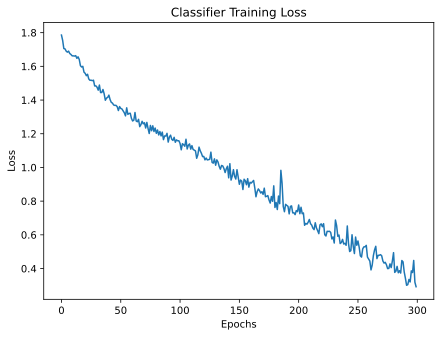

In [70]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(losses.cpu().numpy())
ax.set_title('Classifier Training Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.show()

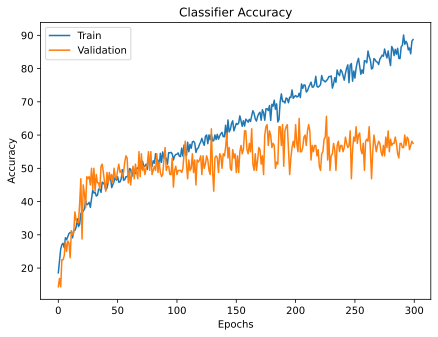

Mean training Accuracy on last 10 epochs:  87.33%
Mean validation Accuracy on last 10 epochs:  57.56%


In [81]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(train_acc)
ax.plot(val_acc)
ax.set_title('Classifier Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

print("Mean training Accuracy on last 10 epochs: ", f"{np.mean(train_acc[-10:]):.2f}%")
print("Mean validation Accuracy on last 10 epochs: ", f"{np.mean(val_acc[-10:]):.2f}%")

In [ ]:
# autoencoder = Autoencoder().to(device)
# classifier = Classifier(num_classes=num_classes).to(device)


# checkpoint = torch.load("models/model2811.pth", map_location=device)
# autoencoder.encoder.load_state_dict(checkpoint['encoder'])
# classifier.load_state_dict(checkpoint['model_state'])
# autoencoder.eval()
# classifier.eval()


# with torch.no_grad():
#     images, labels = next(iter(test_loader))
#     images = images.to(device)
#     latent = autoencoder.encoder(images)
#     outputs = classifier(latent)
# _, preds = torch.max(outputs,1)
# print("Predicted classes:", preds.cpu().numpy())
# print("True classes:     ", labels.numpy())

Predicted classes: [2 5 4 0 1 3 0 0 1 1 3 1 0 5 0 0 2 2 1 4 1 4 0 5 2 5 1 3 1 4 1 0]
True classes:      [2 5 4 1 1 3 1 1 1 0 3 1 0 5 0 2 2 2 0 2 4 4 0 5 2 5 1 3 4 4 4 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


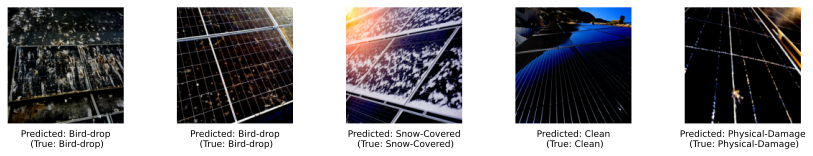

In [ ]:
autoencoder.eval()
classifier.eval()
with torch.no_grad():
    
    images, labels = random.choice(list(test_loader))
    images = images.to(device)

    latent = autoencoder.encoder(images)
    output = classifier(latent)
    preds = torch.argmax(output, 1)

    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()


num_images = 5
plt.figure(figsize=(12, 4))
for i in range(num_images):
    
    plt.subplot(2, num_images, i+1)
    plt.imshow(images[i].permute(1,2,0).numpy())
    plt.axis("off")
    true_label = dataset.classes[labels[i].item()]
    pred_label = dataset.classes[preds[i].item()]
    plt.text(
        0.5, -0.20,
        f"Predicted: {pred_label}\n (True: {true_label})",
        fontsize=9,
        ha="center",
        transform=plt.gca().transAxes
    )
    

plt.tight_layout()
plt.show()

Test Accuracy:  68.12%


<Figure size 800x800 with 0 Axes>

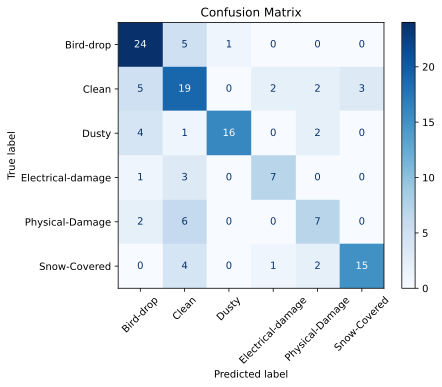

In [97]:
all_preds = []
all_labels = []
test_acc  = []

autoencoder.encoder.eval()
classifier.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        latent = autoencoder.encoder(images)
        outputs = classifier(latent)

        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        test_acc.append(100*torch.mean((preds == labels).float()).item())

print("Test Accuracy: ", f"{np.mean(test_acc):.2f}%")
cm = confusion_matrix(np.concatenate(all_labels), np.concatenate(all_preds))

plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

In [ ]:
date_str = datetime.now().strftime("%y%m%d")
torch.save({
    'epoch': epoch,
    'encoder': autoencoder.encoder.state_dict(),
    'model_state': classifier.state_dict(),
    'optimizer_state': optimizer.state_dict(),
}, f"models/model{date_str}.pth")